# Layout
# update !!!!
+ Searching text for keywords
+ Distribution of terms
+ Correlation
+ Word frequencies
+ Conditional frequencies
+ Statistically significant collocations
    + NEEDS to be added
    + maybe trigrams
+ Distinguishing or Important words and phrases (Wordls!)
    + tf-idf
        + next week
+ POS-tagged words and phrases
+ Lemmatized words and phrases
    + stemmers
+ Dictionary-based annotations.

+ divergences
    + kl
    + Needs to be added

+ Sources
    + US senate press releases
        + e.g. [http://www.reid.senate.gov/press_releases](http://www.reid.senate.gov/press_releases)
    + Tumblr
    + Literature

+ More headers
+ More topic based less narrative

%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')



# Week 2 - Corpus Linguistics

Intro stuff

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
import requests #for http requests
import nltk #the Natural Language Toolkit
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For KL divergence
import scipy #For KL divergence

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

import json #For API responses
import urllib.parse #For joining urls

# Getting our corpuses

To get started we will need some targets, lets start by downloading one of the corpuses from `nltk`. Lets take a look at how that works.

First we can get a list of works available from the Gutenburg corpus, with the [corpus module](http://www.nltk.org/api/nltk.corpus.html).

In [2]:
print(nltk.corpus.gutenberg.fileids())
print(len(nltk.corpus.gutenberg.fileids()))

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']
18


We can also look at the individual works

In [3]:
nltk.corpus.gutenberg.raw('shakespeare-macbeth.txt')[:1000]

"[The Tragedie of Macbeth by William Shakespeare 1603]\n\n\nActus Primus. Scoena Prima.\n\nThunder and Lightning. Enter three Witches.\n\n  1. When shall we three meet againe?\nIn Thunder, Lightning, or in Raine?\n  2. When the Hurley-burley's done,\nWhen the Battaile's lost, and wonne\n\n   3. That will be ere the set of Sunne\n\n   1. Where the place?\n  2. Vpon the Heath\n\n   3. There to meet with Macbeth\n\n   1. I come, Gray-Malkin\n\n   All. Padock calls anon: faire is foule, and foule is faire,\nHouer through the fogge and filthie ayre.\n\nExeunt.\n\n\nScena Secunda.\n\nAlarum within. Enter King Malcome, Donalbaine, Lenox, with\nattendants,\nmeeting a bleeding Captaine.\n\n  King. What bloody man is that? he can report,\nAs seemeth by his plight, of the Reuolt\nThe newest state\n\n   Mal. This is the Serieant,\nWho like a good and hardie Souldier fought\n'Gainst my Captiuitie: Haile braue friend;\nSay to the King, the knowledge of the Broyle,\nAs thou didst leaue it\n\n   Cap. 

All the listed works have been nicely marked up and classified for us so we can do much better than just looking at raw text.

In [4]:
print(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))
print(nltk.corpus.gutenberg.sents('shakespeare-macbeth.txt'))

['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', ...]
[['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', 'William', 'Shakespeare', '1603', ']'], ['Actus', 'Primus', '.'], ...]


If we want to do some analysis we can start by simply counting the number of times each word occurs.

In [5]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

countedWords = wordCounter(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))
countedWords[:10]

,count,word
0,1,captaines
1,1,dreyne
2,1,disposition
3,5,foule
4,1,charnell
5,34,man
6,1,greyhounds
7,1,rung
8,6,another
9,4,knocke


Notice how `wordCounter()` is not a very complicated function. That is because the hard parts have already been done by `nltk`. If we were using unprocessed text we would have to tokenize and determine what to do with the non-word characters.

Lets plot our counts and see what it looks like.

First we need to sort the words by count.

In [6]:
#Doing this in place as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:10]

,count,word
361,1962,","
787,1235,.
1821,650,the
84,637,'
2538,546,and
3125,477,:
837,384,to
1781,348,i
2838,338,of
3034,241,?


The punctuation and very common words (like 'a' and 'the') makes up all the top most common values, this isn't very interesting and can actually get in the way of analysis. We will be removing these later on.

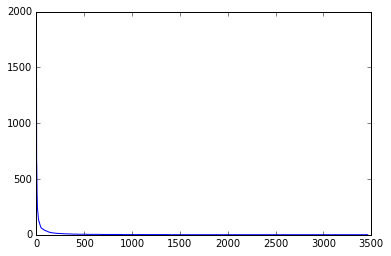

In [7]:
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows the likelihood of a word occurring is inversely proportional to its rank, this effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law).

What does the distribution of word lengths look like?

There are many other properties of words we can look at. First lets look at concordance.

To do this we need to load the text into a `ConcordanceIndex`

In [8]:
macbethIndex = nltk.text.ConcordanceIndex(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))

Then we can get all the words that cooccur with a word, lets look at `'macbeth'`.

In [9]:
macbethIndex.print_concordance('macbeth')

No matches


weird, `'macbeth'` doesn't occur anywhere in the the text. What happened?

`ConcordanceIndex` is case sensitive, lets try looking for `'Macbeth'`

In [10]:
macbethIndex.print_concordance('Macbeth')

Displaying 25 of 61 matches:
                                  Macbeth by William Shakespeare 1603 ] Act
 the Heath 3 . There to meet with Macbeth 1 . I come , Gray - Malkin All . 
but all ' s too weake : For braue Macbeth ( well hee deserues that Name ) D
smay ' d not this our Captaines , Macbeth and Banquoh ? Cap . Yes , as Spar
, And with his former Title greet Macbeth Rosse . Ile see it done King . Wh
 King . What he hath lost , Noble Macbeth hath wonne . Exeunt . Scena Terti
ithin . 3 . A Drumme , a Drumme : Macbeth doth come All . The weyward Siste
, the Charme ' s wound vp . Enter Macbeth and Banquo . Macb . So foule and 
an : what are you ? 1 . All haile Macbeth , haile to thee Thane of Glamis 2
hee Thane of Glamis 2 . All haile Macbeth , haile to thee Thane of Cawdor 3
hee Thane of Cawdor 3 . All haile Macbeth , that shalt be King hereafter Ba
. Hayle 3 . Hayle 1 . Lesser than Macbeth , and greater 2 . Not so happy , 
hough thou be none : So all haile Macbeth , and Banquo 1 . 

That's a lot better

what about something a lot less frequent

In [11]:
print(countedWords[countedWords['word'] == 'Donalbaine'])
macbethIndex.print_concordance('Donalbaine')

Empty DataFrame
Columns: [count, word]
Index: []
Displaying 7 of 7 matches:
m within . Enter King Malcome , Donalbaine , Lenox , with attendants , mee
Enter King , Lenox , Malcolme , Donalbaine , and Attendants . King . Is ex
rches . Enter King , Malcolme , Donalbaine , Banquo , Lenox , Macduff , Ro
 ' th ' second Chamber ? Lady . Donalbaine Mac . This is a sorry sight Lad
er , and Treason , Banquo , and Donalbaine : Malcolme awake , Shake off th
to brag of . Enter Malcolme and Donalbaine . Donal . What is amisse ? Macb
were subborned , Malcolme , and Donalbaine the Kings two Sonnes Are stolne


# Getting press releases

First we need to understand the GitHub API

requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [12]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['private', 'url', 'compare_url', 'trees_url', 'has_downloads', 'branches_url', 'events_url', 'ssh_url', 'collaborators_url', 'forks_url', 'size', 'languages_url', 'releases_url', 'git_commits_url', 'subscription_url', 'keys_url', 'commits_url', 'stargazers_url', 'contents_url', 'milestones_url', 'subscribers_count', 'statuses_url', 'owner', 'git_refs_url', 'open_issues_count', 'pulls_url', 'forks', 'updated_at', 'description', 'git_tags_url', 'issue_events_url', 'hooks_url', 'merges_url', 'pushed_at', 'html_url', 'mirror_url', 'issue_comment_url', 'archive_url', 'forks_count', 'full_name', 'name', 'has_pages', 'has_issues', 'assignees_url', 'fork', 'issues_url', 'language', 'watchers', 'deployments_url', 'svn_url', 'downloads_url', 'id', 'blobs_url', 'comments_url', 'teams_url', 'created_at', 'has_wiki', 'network_count', 'open_issues', 'watchers_count', 'labels_url', 'clone_url', 'contributors_url', 'stargazers_count', 'subscribers_url', 'default_branch', 'homepage', 'notifi

What we are interested in is the `'contents_url'`

In [13]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any, or all of the files from the repo

In [14]:
r= requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'_links': {'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
  'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master'},
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'type': 'file',
 'url': 'https://api.github.com/r

Now we have a list of information about Whitehouse press releases. Lets look at one of them.

In [15]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a blob of text we first need to tokenize it.

In [16]:
whTokens = nltk.word_tokenize(whitehouseRelease)
whTokens[:10]

['SEN.',
 'WHITEHOUSE',
 'SHARES',
 'WESTERLY',
 'GIRL',
 "'S",
 'STORY',
 'IN',
 'PUSH',
 'FOR']

`whTokens` is a list of 'words', it's better than `.split(' ')`,  but it is not perfect. There are many different ways to tokenize a string and the one we used here is called the [Penn Treebank tokenizer](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.treebank). This tokenizer isn't aware of sentences and is a basically a complicated regex that's run over the string.

If we want to find sentences we can use something like `nltk.sent_tokenize()` which implements the [Punkt Sentence tokenizer](http://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.punkt.PunktSentenceTokenizer), a machine learning based algorithm that works well for many European languages.

We could also use the [Stanford tokenizer](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.stanford) or use our own regex with [`RegexpTokenizer()`](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.regexp). Picking the correct tokenizer is important as the tokens form the base of our analysis.

For now though the Penn Treebank tokenizer is fine.

To use the list of tokens in `nltk` we can convert it into a `Text`.

In [17]:
whText = nltk.Text(whTokens)

*Note*, The `Text` class is for doing exploratory and fast analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control. When you are doing a full analysis you should be using the module for that task instead of the method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we got this loaded lets, look at few things

We can find words that tend to occur together

In [18]:
whText.collocations()

Rhode Island; stem cells; cell research; Cell Enhancement; Enhancement
Act; President Bush; Stem Cell; stem cell; Stem cell


Or we can pick a word (or words) and find what words tend to occur around it

In [19]:
whText.common_contexts(['stem'])

own_cells the_cell for_cell ``_cell hope_cell of_cell ._cell on_cells
embryonic_cells


We can also just count the number of times the word occurs

In [20]:
whText.count('stem')

7

Or plot each time it occurs

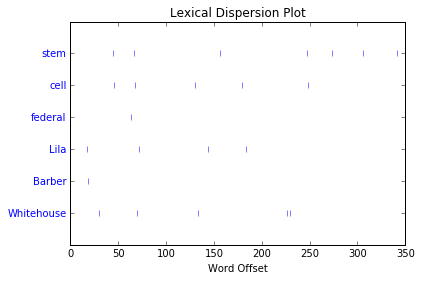

In [21]:
whText.dispersion_plot(['stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs look at the 1st notebook

In [22]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,download_url,html_url,name,path,text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Whitehouse123.txt,raw/Whitehouse/10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse2.txt,raw/Whitehouse/10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse3.txt,raw/Whitehouse/10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2007Whitehouse78.txt,raw/Whitehouse/10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Whitehouse35.txt,raw/Whitehouse/10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...


Now we have all the texts in a DataFrame we can look at a few things.

First lets tokenize the texts with the same tokenizer as we used before, we will just save the tokens as a list for now, no need to convert to `Text`s.

In [23]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: nltk.word_tokenize(x))

Now lets see how long each of the press releases is

In [24]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    397
1    344
2    553
3    216
4    257
5    380
6    270
7    521
8    484
9    482
Name: word_counts, dtype: int64

As we want to start comparing the different releases we need to do a bit of normalizing. We first will make all the words lower case, drop the non-word tokens, then we can stem them and finally remove some stop words.

To do this we will define a function to work over the tokenized lists, then use another apply to add the normalized tokens to a new column.

In [25]:
stopwords = ["the","it","she","he", "a"]

def normlizeTokens(tokenLst, stopwordLst = stopwords):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #The stemmer needs to be initialized before bing run
    porter = nltk.stem.porter.PorterStemmer()

    #Now we can use it
    workingIter = (porter.stem(w) for w in workingIter)

    #We will return a list with the stopwords removed
    return [w for w in workingIter if w not in stopwordLst]

whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normlizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

,download_url,html_url,name,path,text,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Whitehouse123.txt,raw/Whitehouse/10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,"[SEN., WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S,...",397,"[whitehous, share, westerli, girl, stori, in, ...",301
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse2.txt,raw/Whitehouse/10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,"[SEN., WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST...",344,"[whitehous, say, presid, bush, must, begin, br...",272
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse3.txt,raw/Whitehouse/10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",553,"[epa, must, review, legal, process, to, root, ...",424
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2007Whitehouse78.txt,raw/Whitehouse/10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,"[R.I, ., SENATORS, PRAISE, SEN, ., DENIAL, OF,...",216,"[senat, prais, sen, denial, of, lng, facil, pe...",158
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Whitehouse35.txt,raw/Whitehouse/10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,"[SEN., WHITEHOUSE, COMMENTS, ON, ONE-YEAR, ANN...",257,"[whitehous, comment, on, anniversari, of, pres...",203
5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Mar2008Whitehouse8.txt,raw/Whitehouse/10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...","[SENS, ., REED, ,, WHITEHOUSE, WELCOME, RHODE,...",380,"[sen, reed, whitehous, welcom, rhode, island, ...",279
6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Sep2007Whitehouse72.txt,raw/Whitehouse/10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,"[REP., WHITEHOUSE, ISSUES, STATEMENT, ON, GEN....",270,"[whitehous, issu, statement, on, petraeu, iraq...",207
7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Apr2007Whitehouse122.txt,raw/Whitehouse/11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,"[SEN., WHITEHOUSE, URGES, BUSH, FOR, NEW, DIRE...",521,"[whitehous, urg, bush, for, new, direct, in, i...",408
8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Jan2007Whitehouse161.txt,raw/Whitehouse/11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...","[SENS, ., REED, ,, WHITEHOUSE, URGE, PORTUGAL,...",484,"[sen, reed, whitehous, urg, portug, to, recons...",392
9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Mar2008Whitehouse7.txt,raw/Whitehouse/11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,"[WHITEHOUSE, UNVEILS, 'BUSH, DEBT, ', :, $, 7....",482,"[whitehous, unveil, debt, trillion, in, forego...",361


The stemmer we use here is called the [Porter Stemmer](http://www.nltk.org/api/nltk.stem.html#module-nltk.stem.porter), there are many others, including another good one by the same person (Martin Porter) called the [Snowball Stemmer](http://www.nltk.org/api/nltk.stem.html#module-nltk.stem.snowball).

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency disruptions for the dataset. Lets start looking at all the press releases together. The[`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in a iterable of tuples, the first element is the condition and the second the word, for now we will use word lengths as the conditions, but tags or clusters would provide more useful results.

In [26]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of conditions
print(whcfdist.N())

3005


From this we can lookup the distributions of different word lengths

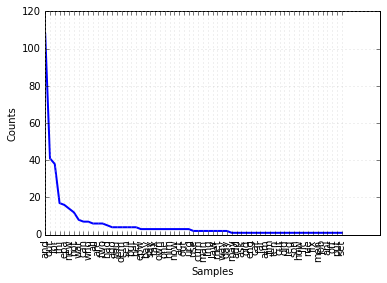

In [27]:
whcfdist[3].plot()

We can also create a [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`, to do this though we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate.

In [28]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

to
0.22639691714836224


Word lengths are a good start but there are many more Important features we care about. To start with we will be classifying words with their part of speech (POS), using the [`nltk.pos_tag()`](http://www.nltk.org/api/nltk.tag.html#nltk.tag.pos_tag).

In [29]:
whReleases['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in whReleases['normalized_tokens']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now make another conditional frequency distribution.

In [30]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('deliv', FreqDist({'NN': 1, 'VB': 1})),
 ('qualiti', FreqDist({'NN': 2})),
 ('waiver', FreqDist({'NN': 2, 'WDT': 1})),
 ('offic', FreqDist({'JJ': 1})),
 ('send', FreqDist({'VB': 1, 'VBP': 1})),
 ('diseas', FreqDist({'NNS': 2})),
 ('plan', FreqDist({'NN': 4})),
 ('man', FreqDist({'NN': 2})),
 ('lose', FreqDist({'JJ': 1})),
 ('come', FreqDist({'VB': 5}))]

This gives the frequency of each word being each part of speech, which is usually quite boring.

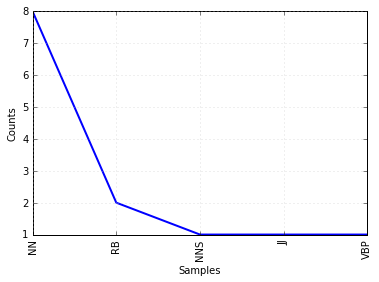

In [31]:
whcfdist_WordtoPOS['administr'].plot()

What we want is the the other direction, the frequency of each part of speech for each word.

In [32]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now get all of the superlative adjectives

In [33]:
whcfdist_POStoWord['JJS']

FreqDist({'best': 2, 'most': 2, 'strongest': 1})

Or look at the most common nouns

In [34]:
whcfdist_POStoWord['NN'].most_common(5)

[('bush', 25), ('presid', 21), ('troop', 19), ('island', 19), ('rhode', 19)]

Or plot the base form verbs against their number of occurrences

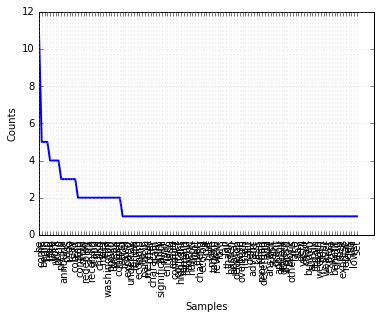

In [35]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the probabilities

In [36]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

bush
0.018518518518518517


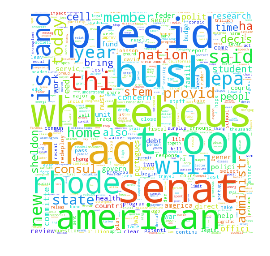

In [37]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

We also might want to find significant bigrams and trigrams. To do this we will use the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-gram.

In [38]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 3005 bigrams in the finder


There are a lot of bigrams, but most of them only occur once, we should first filter our set to remove some of the least common.

In [39]:
#This modifies the finder inplace
whBigrams.apply_freq_filter(2)
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 3005 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is, for now we will just look at the raw counts.

In [40]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('rhode', 'island'), ('presid', 'bush'), ('in', 'iraq'), ('our', 'troop'), ('sheldon', 'whitehous'), ('stem', 'cell'), ('member', 'of'), ('whitehous', 'said'), ('to', 'be'), ('bush', 'administr')]


One note about how `BigramCollocationFinder` works, it doesn't use the strings internally.

In [41]:
def bigramPrinting(count, wordsTuple, total):
    print("The first word is:  {}\nThe second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

print(whBigrams.nbest(bigramPrinting, 10))

The first word is:  8
The second word is: 108
The first word is:  32
The second word is: 3
The first word is:  22
The second word is: 3
The first word is:  2
The second word is: 18
The first word is:  36
The second word is: 3
The first word is:  20
The second word is: 20
The first word is:  6
The second word is: 72
The first word is:  115
The second word is: 13
The first word is:  3
The second word is: 20
The first word is:  24
The second word is: 3
The first word is:  115
The second word is: 4
The first word is:  5
The second word is: 72
The first word is:  115
The second word is: 5
The first word is:  2
The second word is: 4
The first word is:  72
The second word is: 14
The first word is:  115
The second word is: 28
The first word is:  3
The second word is: 115
The first word is:  4
The second word is: 117
The first word is:  32
The second word is: 9
The first word is:  15
The second word is: 40
The first word is:  36
The second word is: 2
The first word is:  5
The second word is: 4


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent, this is a common performance optimization.


# KL Divergence

If we want to compare across the different corpus one of the places to start is Kullback-Leibler divergence, which computes the relative entropy between two distributions. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which takes in two arrays of probabilities and computes the KL divergence.

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [42]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,download_url,html_url,name,path,text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse releases

In [43]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: nltk.word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normlizeTokens(x))

Now we need to compare the two collection of words and remove those not found in both and assign the remaining ones indices.

In [44]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

63

Now can count the occurrences of each these words in the corpora and create our arrays. Note, we don't have to use numpy arrays, we could just use a list, but the arrays are faster so we should get in the habit of using them.

In [45]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence

In [46]:
wh_kenDivergence = scipy.special.kl_div(whProbArray, kenProbArray)